### Imports & Add directories to path


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
import os
import matplotlib.pyplot as plt
import scipy.stats

sys.path.insert(0, '/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting')
sys.path.insert(0, '/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/discogan_arch')

### Import DiscoGAN models & add options to model

In [2]:
from disco_gan_model import DiscoGAN
from discogan_with_risk_model_g1_fixed_one_sample import Disco_with_riskGAN
from discogan_arch_options.options import Options
from dataset import *

options = Options(cuda='true', task_name='edges2shoes', model_arch='discogan',which_epoch_load=3)

model_discogan = DiscoGAN(options)
model_discogan_with_risk = Disco_with_riskGAN(options)

### Load Pre-trained G1 & G2 models

In [3]:
path_G1 = 'saved_models/discogan_shoes2edges_epochs98' 
path_G2 = 'saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_one_sample'
model_number = 3 
## Load G1
G1_0_A = torch.load(os.path.join(path_G1, 'model_gen_A-' + str(model_number)))
G1_0_B = torch.load(os.path.join(path_G1, 'model_gen_B-' + str(model_number)))
G1_0_A = G1_0_A.cuda(0)
G1_0_B = G1_0_B.cuda(0)
## Load G2
G2_0_A = torch.load(os.path.join(path_G2, 'model_gen_A-' + str(model_number)))
G2_0_B = torch.load(os.path.join(path_G2, 'model_gen_B-' + str(model_number)))
G2_0_A = G2_0_A.cuda(0)
G2_0_B = G2_0_B.cuda(0)

/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retrieve the original source co

### Load images as data

In [4]:
train_1, train_2, test_1, test_2 = model_discogan.get_data()
train_data = np.concatenate((train_1, train_2))
test_data = np.concatenate((test_1, test_2))
print('Data size: ',np.shape(train_data))
print('Test size: ',np.shape(test_data))

Data size:  (49825,)
Test size:  (400,)


### Import images

In [5]:
model_discogan_with_risk.initialize()

In [6]:
# images = model_discogan_with_risk.get_the_images(data_style_A, data_style_B, 0, with_path=True)
S_A = read_images(train_data, 'A', model_discogan_with_risk.args.image_size)
S_B = read_images(train_data, 'B', model_discogan_with_risk.args.image_size)
print('Edges (S_A) size: ', np.shape(S_A))
print('Shoes (S_B) size: ', np.shape(S_B))
S_A = Variable(torch.FloatTensor(S_A))
S_B = Variable(torch.FloatTensor(S_B))
if model_discogan_with_risk.cuda:
    S_A = S_A.cuda(0)
    S_B = S_B.cuda(0)

Edges (S_A) size:  (49825, 3, 64, 64)
Shoes (S_B) size:  (49825, 3, 64, 64)


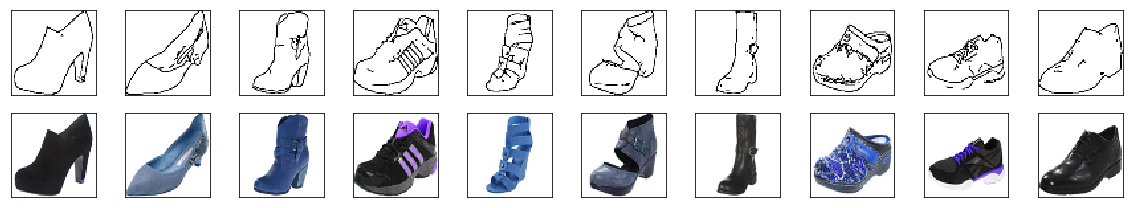

In [7]:
figures = np.zeros((20,3,64,64))
figures[0:10,:,:,:] = S_A[0:10, :, :, :].data.cpu().numpy()
figures[10:20,:,:,:] = S_B[0:10, :, :, :].data.cpu().numpy()
%matplotlib inline
plt.figure(figsize=(16, 3))
for idx, current_image in enumerate(figures[0:10]):
    plt.subplot(2, 10, idx+1)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
for idx, current_image in enumerate(figures[10:20]):
    plt.subplot(2, 10, idx+1+10)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [36]:
def calc_error_bound_and_gt(samples, labels, G1_AB, G2_AB, G1_BA, G2_BA):
    """ 
    This functions calculates the Error bound (correlation loss) per batch
    & the ground truth for G1
    """
#     l1_loss_over_batch = nn.L1Loss(reduce=False)
    l1_loss_over_batch = nn.L1Loss()
    correlation_loss_AB_12 = np.zeros((len(samples)))
    ground_truth_loss_AB_G1 = np.zeros((len(labels)))
    AB_1 = G1_AB(samples)
    AB_2 = G2_AB(samples)
    n_samples = len(samples)
#     print(np.shape(AB_1.data))
#     correlation_loss_AB_12 = - model_discogan_with_risk.correlation_criterion(AB_1, AB_2)
    for sample_idx in np.arange(n_samples):
#         correlation_loss_AB_12[sample_idx] = l1_loss_over_batch(model_discogan_with_risk.to_no_grad_var(AB_1[sample_idx]), model_discogan_with_risk.to_no_grad_var(AB_2[sample_idx]))
        ### IN THE ORIGINAL SCRIPT, THE CORRELATION & GROUND TRUTH LOST WERE MULTIPLIED BY -1 
        correlation_loss_AB_12[sample_idx] = model_discogan_with_risk.correlation_criterion(model_discogan_with_risk.to_no_grad_var(AB_1[sample_idx]), model_discogan_with_risk.to_no_grad_var(AB_2[sample_idx]))
        ground_truth_loss_AB_G1[sample_idx] = model_discogan_with_risk.correlation_criterion(model_discogan_with_risk.to_no_grad_var(AB_1[sample_idx]), model_discogan_with_risk.to_no_grad_var(labels[sample_idx]))
#     print('correlation data shape: ',np.shape(correlation_loss_AB_12.data))
#     return correlation_loss_AB_12.data, ground_truth_loss_AB_G1.data
    return correlation_loss_AB_12, ground_truth_loss_AB_G1

In [44]:
def samples_order_by_loss(S_A, S_B, G1_0_A, G2_0_A, G1_0_B, G2_0_B, n_batch=64, print_freq=100):
    """
    This function sorts a dataset of samples by the error bound (correlation loss)
    It returns a vector of indices, representing the following:
    - loss order (max-->min)
    - loss vector (unordered)
    - ground truth loss vector
    """
#     J_A = np.zeros_like(S_A)
#     J_B = np.zeros_like(S_B)
    n_samples = len(S_A) # number of samples in the dataset
    print('Number of samples: ',n_samples)
    J_loss_val = np.zeros(n_samples, dtype=float) # initalize loss vec
#     J_loss_order = np.zeros(n_samples, dtype=int) # initalize loss order vec
    groud_truth_loss = np.zeros(n_samples, dtype=float) # initalize ground truth loss vec
#     n_iter = int(np.ceil(n_samples/n_batch))
    n_iter = n_samples // n_batch
    print('Number of iterations: ',n_iter)
    for idx in np.arange(n_iter): 
#         print ('Iteration: ',idx)
        J_loss_val[idx*n_batch: (idx+1)*n_batch], groud_truth_loss[idx*n_batch: (idx+1)*n_batch] =\
        calc_error_bound_and_gt(S_A[idx*n_batch: (idx+1)*n_batch, :, :, :],\
                                S_B[idx*n_batch: (idx+1)*n_batch, :, :, :],\
                                G1_0_A, G2_0_A, G1_0_B, G2_0_B) # calculate error bound (loss) per batch
        if idx % print_freq == 0: # printing frequency
            print('Completed ', idx, ' iterations (',idx*n_batch,'samples )')
    print ('Done calculating error bound & ground truth for all samples')
#     sorted_loss, J_loss_order = torch.sort(J_loss_val)
#     sorted_loss, J_loss_order = np.argsort(J_loss_val)
#     print('Before: ',J_loss_val.argsort())
    J_loss_order = J_loss_val.argsort()[::-1][:len(J_loss_val)] # sort max-->min
#     print('After: ',J_loss_order)

    return J_loss_order, J_loss_val, groud_truth_loss 

In [45]:
J_loss_order, J_loss_val, groud_truth_loss = samples_order_by_loss(S_A, S_B, G1_0_A, G2_0_A, G1_0_B, G2_0_B, n_batch=64, print_freq=100)

Number of samples:  49825
Number of iterations:  778
Completed  0  iterations ( 0 samples )
Completed  100  iterations ( 6400 samples )
Completed  200  iterations ( 12800 samples )
Completed  300  iterations ( 19200 samples )
Completed  400  iterations ( 25600 samples )
Completed  500  iterations ( 32000 samples )
Completed  600  iterations ( 38400 samples )
Completed  700  iterations ( 44800 samples )
Done calculating error bound & ground truth for all samples


### Re-order Function & Implementation

In [24]:
### Vectorized implementation (Issues with Pytorch Variable?)
#
# def reorder_samples_by_loss(J_loss_order, S):
#     """
#     This function received:
#     - J_loss_order (the new loss order max-->min) 
#     - S (Domain Dataset to be reordered)
#     """
#     loss_order = torch.from_numpy(J_loss_order.copy()).cuda()
#     S_new = torch.Tensor(S.size()).cuda()
#     S_new.index_copy_(0, loss_order, S.data)
#     S_new = Variable(S_new)
#     return S_new

### Trivial implementation (loop)
def reorder_samples_by_loss(J_loss_order, S):
    """
    This function received:
    - J_loss_order (the new loss order max-->min) 
    - S (Domain Dataset to be reordered)
    """
    S_new = torch.Tensor(S.size()).cuda()
    for idx in np.arange(S.size()[0]):
        S_new[idx, :, :, :] = S.data[J_loss_order[idx], :, :, :]
    return S_new

In [25]:
S_A_reordered = reorder_samples_by_loss(J_loss_order, S_A)
S_A_reordered = Variable(S_A_reordered)
S_B_reordered = reorder_samples_by_loss(J_loss_order, S_B)
S_B_reordered = Variable(S_B_reordered)
if model_discogan_with_risk.cuda:
    S_A_reordered = S_A_reordered.cuda(0)
    S_B_reordered = S_B_reordered.cuda(0)

# print(S_A)
# print (S_A_reordered)

# Evaluate function results

#### Correlation

In [26]:
corr_coeff, p_val = scipy.stats.pearsonr(J_loss_val, groud_truth_loss)
print('Correlation Coefficient: ', corr_coeff)
print('Correlation P-Value: ', p_val)

Correlation Coefficient:  0.382149747296
Correlation P-Value:  0.0


#### Plots

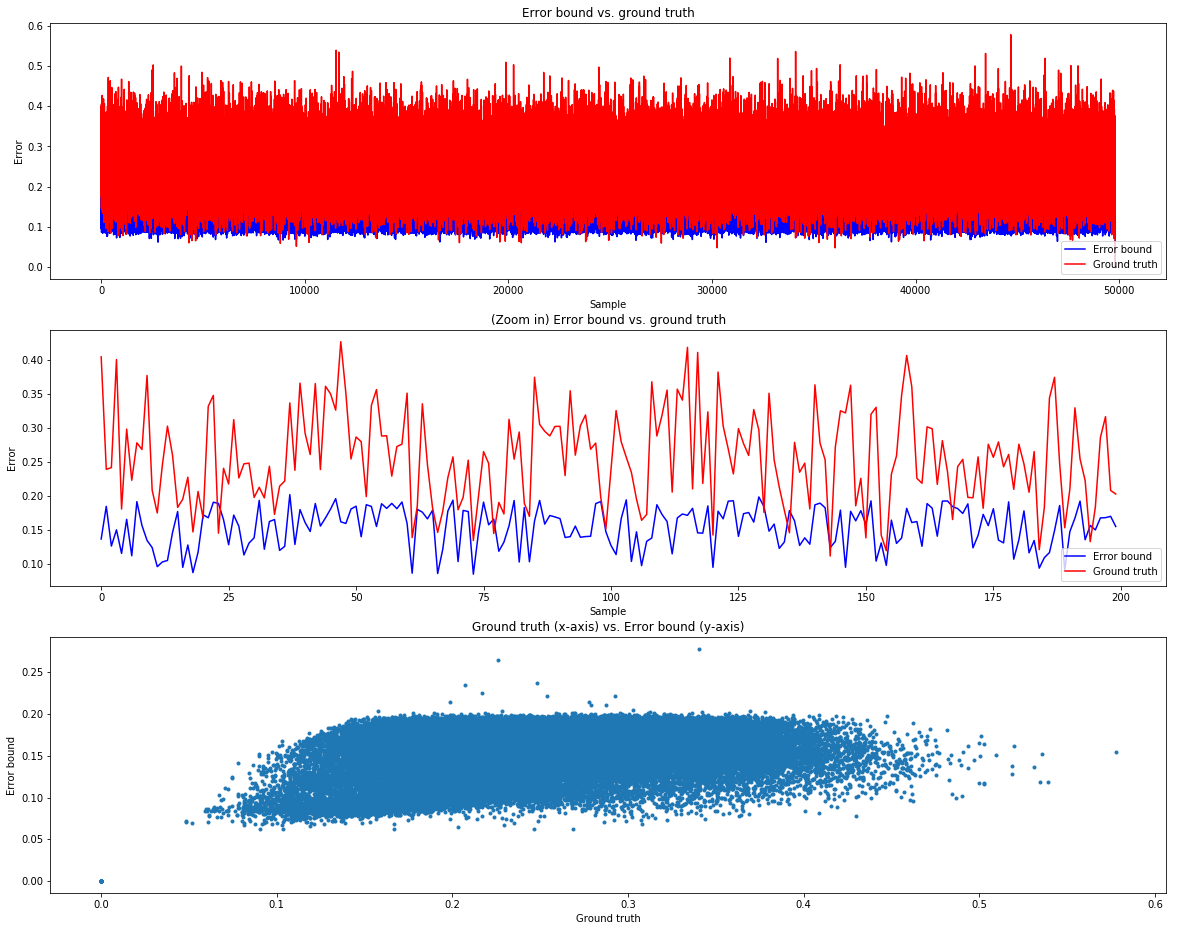

In [27]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.subplot(3,1,1)
plt.plot(J_loss_val, 'b')
plt.plot(groud_truth_loss,'r')

plt.title('Error bound vs. ground truth')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend(['Error bound' ,'Ground truth'], loc=4)

plt.subplot(3,1,2)
plt.plot(J_loss_val[:200], 'b')
plt.plot(groud_truth_loss[:200],'r')

plt.title('(Zoom in) Error bound vs. ground truth')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend(['Error bound' ,'Ground truth'], loc=4)

plt.subplot(3,1,3)
plt.plot(groud_truth_loss, J_loss_val,'.')
plt.title('Ground truth (x-axis) vs. Error bound (y-axis)')
plt.xlabel('Ground truth')
plt.ylabel('Error bound')

plt.show()

# DEBUG

[ 8843  6633 17827 ..., 49807 49804 49824]


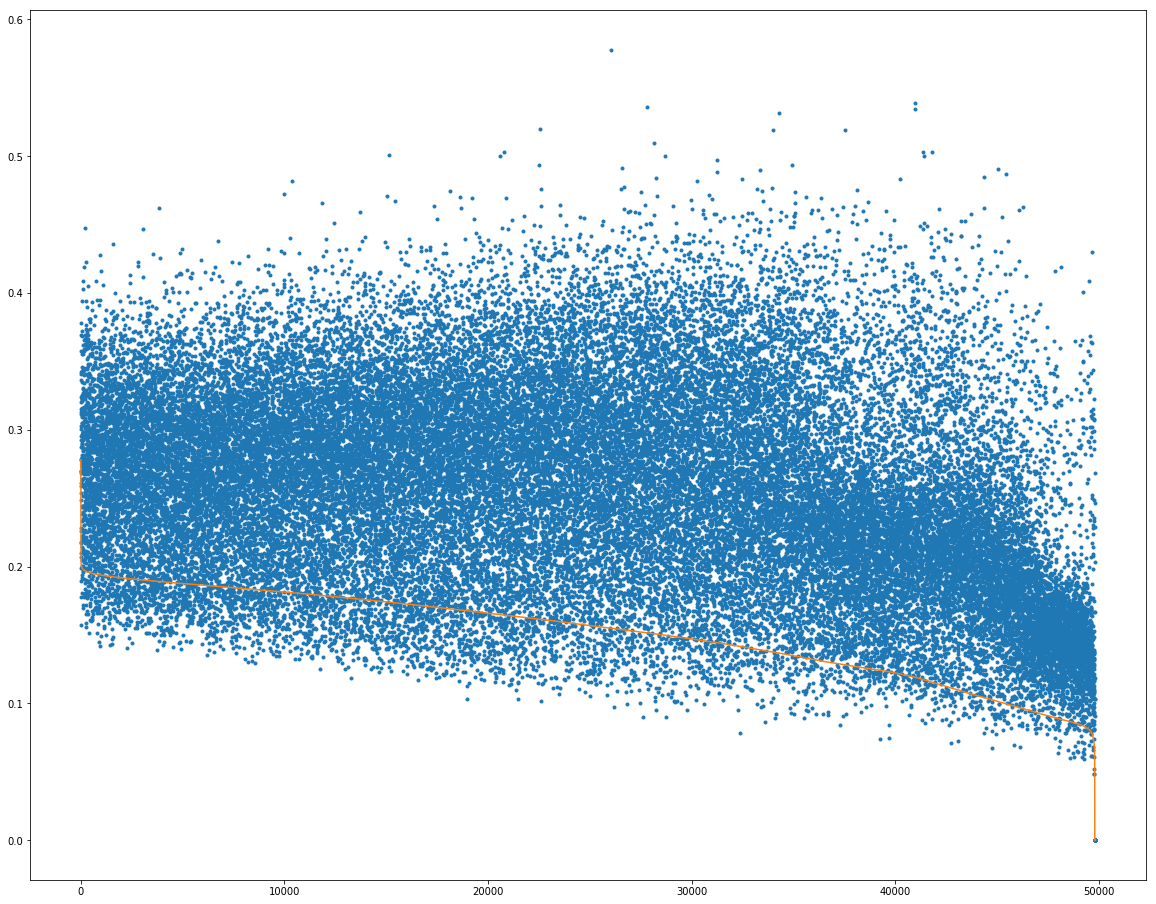

In [28]:
##### DEBUG  #####
print (J_loss_order)
# print(J_loss_val[J_loss_order[0:100]])
# print(J_loss_val[J_loss_order[len(J_loss_val)-100:]])
# print(J_loss_val[0:100])
# print(validate_J_loss_val[0:100])

# Debug plot
plt.plot(groud_truth_loss[J_loss_order],'.')
plt.plot(J_loss_val[J_loss_order])

# Load images again for Debug (reorder then convert to variable)

In [29]:
# # # images = model_discogan_with_risk.get_the_images(data_style_A, data_style_B, 0, with_path=True)
# # S_A = read_images(train_data, 'A', model_discogan_with_risk.args.image_size)
# # S_B = read_images(train_data, 'B', model_discogan_with_risk.args.image_size)
# # print('Edges (S_A) size: ', np.shape(S_A))
# # print('Shoes (S_B) size: ', np.shape(S_B))
# # # S_A = Variable(torch.FloatTensor(S_A))
# # # S_B = Variable(torch.FloatTensor(S_B))
# # # if model_discogan_with_risk.cuda:
# # #     S_A = S_A.cuda(0)
# # #     S_B = S_B.cuda(0)

# S_A_reordered = S_A[J_loss_order, :, :, :]
# S_B_reordered = S_B[J_loss_order, :, :, :]
# S_A_reordered = Variable(torch.FloatTensor(S_A_reordered))
# S_B_reordered = Variable(torch.FloatTensor(S_B_reordered))
# if model_discogan_with_risk.cuda:
#     S_A_reordered = S_A_reordered.cuda(0)
#     S_B_reordered = S_B_reordered.cuda(0)

### Validate Reorder

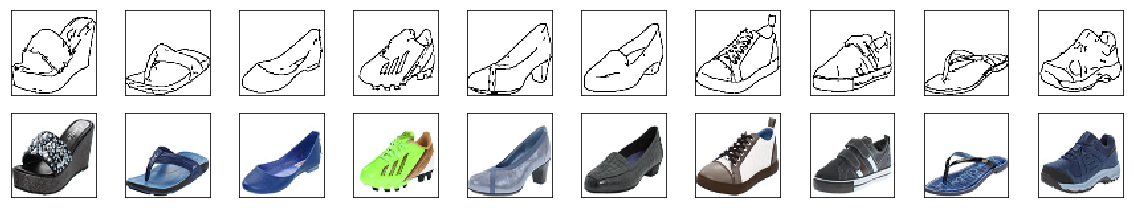

In [30]:
# S_B_reordered = reorder_samples_by_loss(J_loss_order, S_B)
# S_B_reordered = Variable(S_B_reordered)
# if model_discogan_with_risk.cuda:
#     S_B_reordered = S_B_reordered.cuda(0)
figures = np.zeros((20,3,64,64))
figures[0:10,:,:,:] = S_A_reordered[0:10, :, :, :].data.cpu().numpy()
figures[10:20,:,:,:] = S_B_reordered[0:10, :, :, :].data.cpu().numpy()
%matplotlib inline
plt.figure(figsize=(16, 3))
for idx, current_image in enumerate(figures[0:10]):
    plt.subplot(2, 10, idx+1)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
for idx, current_image in enumerate(figures[10:20]):
    plt.subplot(2, 10, idx+1+10)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [46]:
validate_J_loss_order, validate_J_loss_val, validate_groud_truth_loss = samples_order_by_loss(S_A_reordered, S_B_reordered, G1_0_A, G2_0_A, G1_0_B, G2_0_B, n_batch=64, print_freq=100)

Number of samples:  49825
Number of iterations:  778
Completed  0  iterations ( 0 samples )
Completed  100  iterations ( 6400 samples )
Completed  200  iterations ( 12800 samples )
Completed  300  iterations ( 19200 samples )
Completed  400  iterations ( 25600 samples )
Completed  500  iterations ( 32000 samples )
Completed  600  iterations ( 38400 samples )
Completed  700  iterations ( 44800 samples )
Done calculating error bound & ground truth for all samples


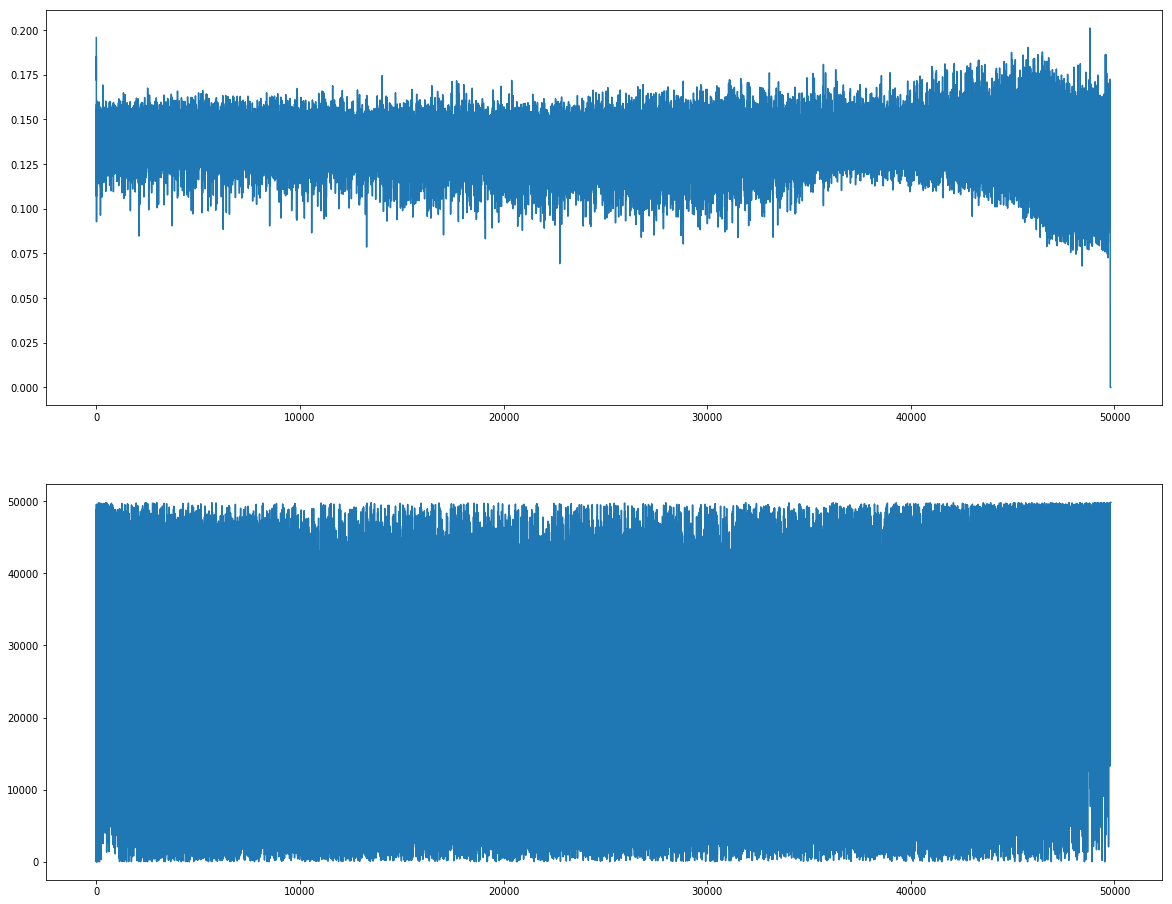

In [32]:
# corr_coeff, p_val = scipy.stats.pearsonr(validate_J_loss_val, J_loss_val)
# print('Correlation Coefficient: ', corr_coeff)
# print('Correlation P-Value: ', p_val)
plt.rcParams['figure.figsize'] = (20.0, 16.0) 

plt.subplot(2,1,1)
plt.plot(validate_J_loss_val)
plt.subplot(2,1,2)
plt.plot(validate_J_loss_order)
